In [5]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from utils import evaluate
from xgboost import XGBClassifier


In [6]:
df = pd.read_csv(r'database\final-interpolated.csv')
df


,Unnamed: 0,ID,pH,BDecf,pCO2,BE,Apgar1,Apgar5,Gest. Weeks,Weight(g),...,Median_UC,Std_FHR,Std_UC,RMS_FHR,RMS_UC,Peak_to_RMS_FHR,Peak_to_RMS_UC,Peak_FHR,Peak_UC,target
0,0,1220.000000,7.300000,3.520000,6.000000,-4.700000,9.000000,10.000000,42.000000,3100.000000,...,23.000000,55.948729,21.970835,125.822264,33.143752,67.177736,93.856248,193.000000,127.000000,1.0
1,1,1234.000000,7.290000,2.500000,6.500000,-4.200000,8.000000,9.000000,41.000000,3200.000000,...,20.500000,50.734943,24.685834,140.395307,34.975993,83.604693,92.024007,224.000000,127.000000,1.0
2,2,1208.000000,7.230000,5.840000,6.600000,-7.400000,9.000000,9.000000,40.000000,3900.000000,...,3.000000,50.552578,21.705502,111.052168,26.323443,63.447832,73.676557,174.500000,100.000000,1.0
3,3,1038.000000,7.330000,2.720000,5.700000,-4.000000,10.000000,10.000000,39.000000,2740.000000,...,6.000000,24.087743,30.393657,136.057873,37.570082,30.692127,62.429918,166.750000,100.000000,1.0
4,4,1004.000000,7.300000,5.190000,5.500000,-6.400000,8.000000,9.000000,41.000000,3370.000000,...,14.000000,51.581668,16.210997,105.951334,22.315540,123.048666,100.684460,229.000000,123.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,970,1612.415502,7.277141,4.170062,6.214293,-5.257210,8.285658,8.714244,39.571415,4014.282925,...,13.642683,66.832155,15.123756,113.061862,21.790416,87.081041,69.994656,200.142902,91.785073,0.0
971,971,1767.337796,7.293675,3.440918,6.131623,-4.463584,8.947013,9.210260,39.736753,4047.350650,...,15.709416,62.646109,17.396235,103.455788,25.123933,96.149764,74.266717,199.605552,99.390650,0.0
972,972,1481.788323,7.230459,4.115599,7.287158,-5.830279,9.440366,10.000000,40.559634,4038.440290,...,15.922014,64.310246,18.569339,110.321673,26.431828,76.815927,77.513116,187.137600,103.944945,0.0
973,973,1199.005821,7.233021,6.115778,6.434896,-7.374997,6.520836,7.390627,39.130209,3926.041797,...,8.127612,78.002607,9.059652,138.695641,12.894938,62.881180,58.594676,201.576821,71.489613,0.0


In [7]:
# droping unnecessary columns
df.drop(['Unnamed: 0', 'ID'], axis=1, inplace=True)
df.shape


(975, 42)

In [8]:
df.isnull().sum().sum()  # checking for null values


0

In [9]:
df.columns


Index(['pH', 'BDecf', 'pCO2', 'BE', 'Apgar1', 'Apgar5', 'Gest. Weeks',
       'Weight(g)', 'Sex', 'Age', 'Gravidity', 'Parity', 'Diabetes',
       'Hypertension', 'Preeclampsia', 'Liq.', 'Pyrexia', 'Meconium',
       'Presentation', 'Induced', 'I.stage', 'NoProgress', 'CK/KP', 'II.stage',
       'Deliv. type', 'dbID', 'Rec. type', 'Pos. II.st.', 'Sig2Birth',
       'Mean_FHR', 'Mean_UC', 'Median_FHR', 'Median_UC', 'Std_FHR', 'Std_UC',
       'RMS_FHR', 'RMS_UC', 'Peak_to_RMS_FHR', 'Peak_to_RMS_UC', 'Peak_FHR',
       'Peak_UC', 'target'],
      dtype='object')

# Feature Engineering

In [10]:
def f(x):
    if 6.5 < x <= 10:
        return 'Excellent'
    elif 4 < x <= 6.5:
        return 'ModeratelyAbnormal'
    elif x <= 4:
        return 'Attention'


In [11]:
df['Apgar1'] = df['Apgar1'].apply(lambda x: f(x))
df['Apgar5'] = df['Apgar5'].apply(lambda x: f(x))


In [12]:
df.Apgar1.value_counts()


Excellent             901
ModeratelyAbnormal     47
Attention              27
Name: Apgar1, dtype: int64

In [13]:
df.Apgar5.value_counts()


Excellent             957
ModeratelyAbnormal     15
Attention               3
Name: Apgar5, dtype: int64

In [14]:
df.target.value_counts()


1.0    488
0.0    487
Name: target, dtype: int64

In [15]:
df['pH'] = df['pH'].apply(lambda x: 'Pathological' if x <= 7.15 else 'Normal')

df.pH.value_counts()


Normal          842
Pathological    133
Name: pH, dtype: int64

In [16]:
# one hot encoding
dts = pd.get_dummies(df)
df.shape


(975, 42)

In [17]:
dts.head()


,BDecf,pCO2,BE,Gest. Weeks,Weight(g),Sex,Age,Gravidity,Parity,Diabetes,...,Peak_UC,target,pH_Normal,pH_Pathological,Apgar1_Attention,Apgar1_Excellent,Apgar1_ModeratelyAbnormal,Apgar5_Attention,Apgar5_Excellent,Apgar5_ModeratelyAbnormal
0,3.52,6.0,-4.7,42.0,3100.0,2.0,34.0,2.0,2.0,0.0,...,127.0,1.0,1,0,0,1,0,0,1,0
1,2.50,6.5,-4.2,41.0,3200.0,1.0,29.0,1.0,0.0,0.0,...,127.0,1.0,1,0,0,1,0,0,1,0
2,5.84,6.6,-7.4,40.0,3900.0,2.0,26.0,1.0,0.0,0.0,...,100.0,1.0,1,0,0,1,0,0,1,0
3,2.72,5.7,-4.0,39.0,2740.0,1.0,24.0,1.0,1.0,0.0,...,100.0,1.0,1,0,0,1,0,0,1,0
4,5.19,5.5,-6.4,41.0,3370.0,1.0,36.0,1.0,0.0,0.0,...,123.0,1.0,1,0,0,1,0,0,1,0


In [18]:
dts.columns


Index(['BDecf', 'pCO2', 'BE', 'Gest. Weeks', 'Weight(g)', 'Sex', 'Age',
       'Gravidity', 'Parity', 'Diabetes', 'Hypertension', 'Preeclampsia',
       'Liq.', 'Pyrexia', 'Meconium', 'Presentation', 'Induced', 'I.stage',
       'NoProgress', 'CK/KP', 'II.stage', 'Deliv. type', 'dbID', 'Rec. type',
       'Pos. II.st.', 'Sig2Birth', 'Mean_FHR', 'Mean_UC', 'Median_FHR',
       'Median_UC', 'Std_FHR', 'Std_UC', 'RMS_FHR', 'RMS_UC',
       'Peak_to_RMS_FHR', 'Peak_to_RMS_UC', 'Peak_FHR', 'Peak_UC', 'target',
       'pH_Normal', 'pH_Pathological', 'Apgar1_Attention', 'Apgar1_Excellent',
       'Apgar1_ModeratelyAbnormal', 'Apgar5_Attention', 'Apgar5_Excellent',
       'Apgar5_ModeratelyAbnormal'],
      dtype='object')

# Test  Train Split

In [19]:
X = dts.drop('target', axis=1)
y = dts['target']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
print('Training dataset len: {}, Test data len: {}'.format(
    X_train.shape[0], y_test.shape[0]))


Training dataset len: 780, Test data len: 195


# Scaling Dataset

In [21]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test = sc.transform(X_test)


# Training Different Models

## KNN

In [22]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)


KNeighborsClassifier()

In [23]:
y_pred = model_knn.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 83.59%


In [24]:
evaluate.evaluate_model(model_knn, X_test, y_test)


Accuracy:- 83.59%
Confusion matrix :- 
 [[97  0]
 [32 66]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.75      1.00      0.86        97
         1.0       1.00      0.67      0.80        98

    accuracy                           0.84       195
   macro avg       0.88      0.84      0.83       195
weighted avg       0.88      0.84      0.83       195



## Support Vector Machines

In [26]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

evaluate.evaluate_model(model, X_test, y_test)


Accuracy:- 88.21%
Confusion matrix :- 
 [[94  3]
 [20 78]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.82      0.97      0.89        97
         1.0       0.96      0.80      0.87        98

    accuracy                           0.88       195
   macro avg       0.89      0.88      0.88       195
weighted avg       0.89      0.88      0.88       195



In [27]:
model = SVC(kernel='rbf')
model.fit(X_train, y_train)

evaluate.evaluate_model(model, X_test, y_test)


Accuracy:- 96.41%
Confusion matrix :- 
 [[97  0]
 [ 7 91]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.93      1.00      0.97        97
         1.0       1.00      0.93      0.96        98

    accuracy                           0.96       195
   macro avg       0.97      0.96      0.96       195
weighted avg       0.97      0.96      0.96       195



## Random Forest Classifier

In [28]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

evaluate.evaluate_model(model, X_test, y_test)


Accuracy:- 98.46%
Confusion matrix :- 
 [[97  0]
 [ 3 95]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        97
         1.0       1.00      0.97      0.98        98

    accuracy                           0.98       195
   macro avg       0.98      0.98      0.98       195
weighted avg       0.99      0.98      0.98       195



## XGBoost

In [30]:
model = XGBClassifier(eval_metric='mlogloss', objective='binary:logistic', use_label_encoder=False)
model.fit(X_train, y_train)

evaluate.evaluate_model(model, X_test, y_test)


Accuracy:- 95.38%
Confusion matrix :- 
 [[93  4]
 [ 5 93]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95        97
         1.0       0.96      0.95      0.95        98

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



# Hyperparameter Tuning with Grid Search

So, we have 3 candidates who performed well XGboost, Randomforest, SVM (rbf kernel)

In [31]:
def hyperparameter_tuning(model, parameters, X_train, y_train):

    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5,  n_jobs=5,
                        scoring='roc_auc', refit=True, verbose=1)

    grid.fit(X_train, y_train)
    print("Best Score (AUC ROC): {}".format(grid.best_score_*100))
    print("Best Parameters:", grid.best_params_)
    best_model = grid.best_estimator_
    return best_model


## Tuning RandomForest

In [33]:
param_grid = {
    'n_estimators': [200, 500, 700, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 15, 30, 50, 100, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

best_rf = hyperparameter_tuning(
    RandomForestClassifier(), param_grid, X_train, y_train)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Score (AUC ROC): 99.63839579224197
Best Parameters: {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [34]:
evaluate.evaluate_model(best_rf, X_test, y_test)


Accuracy:- 97.95%
Confusion matrix :- 
 [[96  1]
 [ 3 95]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        97
         1.0       0.99      0.97      0.98        98

    accuracy                           0.98       195
   macro avg       0.98      0.98      0.98       195
weighted avg       0.98      0.98      0.98       195



## Tuning SVM

In [35]:
param_grid = {
    'C': [0.1, 0.25, 0.5, 0.75, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5, 6],
    'decision_function_shape': ('ovo', 'ovr'),
    'shrinking': (True, False)
}

best_svc = hyperparameter_tuning(
    SVC(), param_grid, X_train, y_train)


Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
Best Score (AUC ROC): 99.83892176199868
Best Parameters: {'C': 10, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'shrinking': True}


In [36]:
evaluate.evaluate_model(best_svc, X_test, y_test)


Accuracy:- 98.46%
Confusion matrix :- 
 [[97  0]
 [ 3 95]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        97
         1.0       1.00      0.97      0.98        98

    accuracy                           0.98       195
   macro avg       0.98      0.98      0.98       195
weighted avg       0.99      0.98      0.98       195



## Tuning XGBoost

In [37]:
param_grid = {
    'use_label_encoder': [False],
    'eval_metric': ['mlogloss'],
    'objective': ['binary:logistic'],
    'learning_rate': [0.01, 0.05, 0.02],
    'subsample': [0.7, 0.8, 1.0],  # % of rows taken to build each tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # number of columns used by each tree
    'max_depth': [7, 5],  # depth of each tree
    'n_estimators': [100, 200, 300, 500],  # no. of trees
    'reg_alpha': [1.1, 1.2],
    'reg_lambda': [1.1, 1.3],
}
best_xgb = hyperparameter_tuning(
    XGBClassifier(), param_grid, X_train, y_train)


Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best Score (AUC ROC): 99.44115713346481
Best Parameters: {'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'reg_alpha': 1.2, 'reg_lambda': 1.1, 'subsample': 0.7, 'use_label_encoder': False}


In [38]:
evaluate.evaluate_model(best_xgb, X_test, y_test)


Accuracy:- 96.92%
Confusion matrix :- 
 [[95  2]
 [ 4 94]]
Classification Report:-
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97        97
         1.0       0.98      0.96      0.97        98

    accuracy                           0.97       195
   macro avg       0.97      0.97      0.97       195
weighted avg       0.97      0.97      0.97       195



# AUC ROC

AUC ROC Scores
XGBoost: 	 0.9692825583841784
RandomForest: 	 0.9795392383757626
SupportVectorMachines: 	 0.9846938775510203


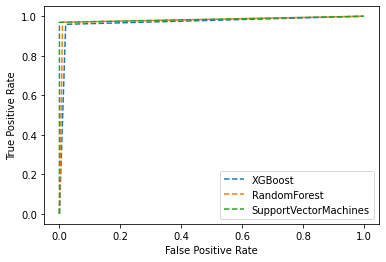

In [40]:
evaluate.plot_auc_roc([('XGBoost', best_xgb), ('RandomForest', best_rf), ('SupportVectorMachines', best_svc)], X_test, y_test)
